# Unet

In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

## Modeling

In [5]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # conv 3x3, batch normalization, relu
        def CB(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [
                nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=padding,
                    bias=bias
                )
            ]
            layers += [ nn.BatchNorm2d(num_features=out_channels) ]
            layers += [ nn.ReLU() ]

            conv_block = nn.Sequential(*layers)
            return conv_block
        
        # UNet Encoder
        self.enc1_1 = CB(in_channels=1, out_channels=64)
        self.enc1_2 = CB(in_channels=64, out_channels=64)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CB(in_channels=64, out_channels=128)
        self.enc2_2 = CB(in_channels=128, out_channels=128)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CB(in_channels=128, out_channels=256)
        self.enc3_2 = CB(in_channels=256, out_channels=256)
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CB(in_channels=256, out_channels=512)
        self.enc4_2 = CB(in_channels=512, out_channels=512)
        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CB(in_channels=512, out_channels=1024)

        # UNet Decoder
        self.dec5_1 = CB(in_channels=1024, out_channels=512)

        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2, padding=0, bias=True)

        # in_channels = 512*2인 이유는 encoder에서 사용했던 feature map을 decoder에서도 사용할 수 있도록
        # forward에서 dec와 enc을 concat해주기 때문
        self.dec4_2 = CB(in_channels=512*2, out_channels=512)
        self.dec4_1 = CB(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2, padding=0, bias=True)
        self.dec3_2 = CB(in_channels=256*2, out_channels=256)
        self.dec3_1 = CB(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2, padding=0, bias=True)
        self.dec2_2 = CB(in_channels=128*2, out_channels=128)
        self.dec2_1 = CB(in_channels=128, out_channels=64)
        
        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0, bias=True)
        self.dec1_2 = CB(in_channels=64*2, out_channels=64)
        self.dec1_1 = CB(in_channels=64, out_channels=64)
        
        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

    def forward(self, x):
        # Encoder
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        # Decoder
        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        
        # UNet 구조 중 encoder에서 사용했던 feature map을 decoder에서 동일하게 사용하도록 구축
        # dim=[0:batch, 1:channel, 2:height, 3:width]
        
        cat4 = torch.cat([enc4_2, unpool4], dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat([enc3_2, unpool3], dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat([enc2_2, unpool2], dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat([enc1_2, unpool1])
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)

        return x


## Data

In [4]:
# 데이터 저장경로
data_dir = "data/unet"

name_label = "train-labels.tif"
name_input = "train-volume.tif"

img_label = Image.open(os.path.join(data_dir, name_label))
img_input = Image.open(os.path.join(data_dir, name_input))

ny, nx = img_label.size
nframe = img_label.n_frames

print("nx", nx)
print("ny", ny)
print("frame", nframe)

nx 512
ny 512
frame 30


[27 19  3 24 18 16  0  9  1  8  4 13  2 25 26 10  6  5 11 28 22 14  7 21
 29 17 12 15 20 23]


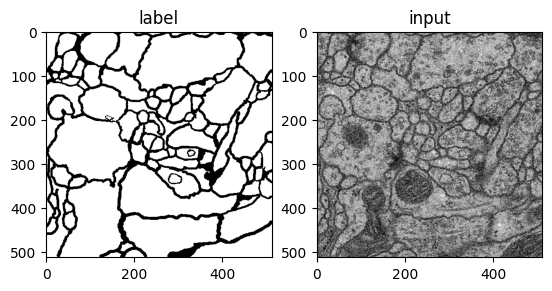

In [7]:
# 데이터는 총 30프레임으로 구성 train:val:test = 24:3:3
nframe_train = 24
nframe_val = 3
nframe_test = 3

# 데이터 나눠서 저장할 경로 설정
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

# 경로 폴더 만들기
if not os.path.exists(train_dir):
    os.makedirs(train_dir)
if not os.path.exists(val_dir):
    os.makedirs(val_dir)
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

# 데이터 랜덤 설정
id_frame = np.arange(nframe)
np.random.shuffle(id_frame)
print(id_frame)

# 데이터 섞어서 train 저장
offset_nframe = 0
for i in range(nframe_train):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(train_dir, f"label_{i:03d}.npy"), label_)
    np.save(os.path.join(train_dir, f"input_{i:03d}.npy"), input_)

# 데이터 섞어서 val 저장
offset_nframe += nframe_train
for i in range(nframe_val):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])
    
    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(val_dir, f"label_{i:03d}.npy"), label_)
    np.save(os.path.join(val_dir, f"input_{i:03d}.npy"), input_)

# 데이터 섞어서 test 저장
offset_nframe += nframe_val
for i in range(nframe_test):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(test_dir, f"label_{i:03d}.npy"), label_)
    np.save(os.path.join(test_dir, f"input_{i:03d}.npy"), input_)
    
# 데이터 확인
plt.subplot(121)
plt.imshow(label_, cmap="gray")
plt.title("label")

plt.subplot(122)
plt.imshow(input_, cmap="gray")
plt.title("input")

plt.show()


## Dataset, DataLoader 구성

In [ ]:
# dataset
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        
        # 데이터 파일 리스트 받기
        lst_data = os.listdir(self.data_dir)

        lst_label = [ f for f in lst_data if f.startswith("label") ]
        lst_input = [ f for f in lst_data if f.startswith("input") ]

        lst_label.sort()
        lst_input.sort()

        self.lst_label = lst_label
        self.lst_input = lst_input

    def __len__(self):
        return len(self.lst_label)
    
    def __getitem__(self, index):
        labels = np.load(os.path.join(self.data_dir, self.lst_label[index]))
        inputs = np.load(os.path.join(self.data_dir, self.lst_input[index]))

        # normalization
        labels = labels/255.0
        inputs = inputs/255.0
        
        # torch 는 반드시 3차원이어야하기 때문에 채널이 없는 경우 채널을 만들어주는 로직
        if labels.ndim == 2:
            labels = labels[:, :, np.newaxis]
        if inputs.ndim == 2:
            inputs = inputs[:, :, np.newaxis]

        data = { "inputs": inputs, "labels": labels}

        if self.transform:
            data = self.transform(data)

        return data
